In [15]:
from matplotlib import pyplot as plt
import numpy as np

In [51]:
from keras.models import load_model
AM = load_model('face_gen.h5')

C:\Users\Konrad\Anaconda3\envs\tensor4\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [52]:
Gen = AM.get_layer("sequential_1")

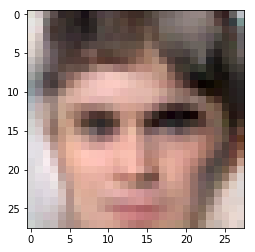

In [61]:
noise = np.random.uniform(-1.0, 1.0, size = [1, 100])
i = Gen.predict(noise)
i = (((i - i.min()) * 255) / (i.max() - i.min())).astype(np.uint8)
plt.imshow(i[0])